# Initialize

In [ ]:
!pip install pytorch-lightning==1.6.5
!pip install pandas numpy opencv-python Pillow scikit-image scikit-learn scipy tqdm fairseq wandb statsmodels
%cd /content/drive/Shareddrives/THESIS/MAIN/visuelle2-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/Shareddrives/THESIS/MAIN/visuelle2-code


In [ ]:
import os
import argparse
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from datetime import datetime
from tqdm import tqdm
from models.Oracle import Oracle
from dataset import Visuelle2
from utils import calc_error_metrics
from matplotlib import pyplot

In [ ]:
def run(args):
    print(args)
    
    # Seed for reproducibility (By default we use the number 21)
    pl.seed_everything(args.seed)

    ####################################### Load data #######################################
    # Load train-test data
    test_df = pd.read_csv(
        os.path.join(args.dataset_path, "stfore_test.csv"),
        parse_dates=["release_date"],
    )
    # Load attribute encodings
    cat_dict = torch.load(os.path.join(args.dataset_path, "category_labels.pt"))
    col_dict = torch.load(os.path.join(args.dataset_path, "color_labels.pt"))
    fab_dict = torch.load(os.path.join(args.dataset_path, "fabric_labels.pt"))

    # Load Google trends
    gtrends = pd.read_csv(
        os.path.join(args.dataset_path, "vis2_gtrends_data.csv"), index_col=[0], parse_dates=True
    )

    img_folder = os.path.join(args.dataset_path, 'images')
    
    if args.new_window == True:
      visuelle_pt_test = "visuelle2_test_processed_stfore_4.pt"
    else:
      visuelle_pt_test = "visuelle2_test_processed_stfore_2.pt"

    # Create (PyTorch) dataset objects
    testset = Visuelle2(
        test_df,
        img_folder,
        gtrends,
        cat_dict,
        col_dict,
        fab_dict,
        args.trend_len,
        args.new_window,
        demand=False, # Can't do demand forecasting of new products with these methods,
        local_savepath=os.path.join(args.dataset_path, visuelle_pt_test)
    )

    # # If you wish to debug with less data you can use this syntax
    # testset = torch.utils.data.Subset(testset, list(range(1000)))

    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0
    )
    
    print("Test batches:", len(testloader))

    # ####################################### Run model #######################################
    # Create model
    model = Oracle(args.method, bool(args.use_teacher_forcing))

    # Perform forecasts
    gt, forecasts = [], []
    for data in tqdm(testloader, total=len(testloader)):
        with torch.no_grad():
            (X, y, _, _, _, _, _, _), _ = data
            y_hat = model(X)
            forecasts.append(y_hat)
            gt.append(y)

    norm_scalar = np.load(os.path.join(args.dataset_path, 'stfore_sales_norm_scalar.npy'))
    gt, forecasts = (
        torch.cat(gt).squeeze().numpy() * norm_scalar,
        torch.cat(forecasts).squeeze().numpy() * norm_scalar,
    )
    mae, wape = calc_error_metrics(gt, forecasts)
    print(f"Results for {args.method}")
    print(f"{wape},{mae}")
    return gt, forecasts


In [ ]:
parser = argparse.ArgumentParser()
# General arguments
parser.add_argument("--dataset_path", type=str, default='visuelle2/')
parser.add_argument("--seed", type=int, default=21)
parser.add_argument("--method", type=str, default="naive")
parser.add_argument("--new_window", type=bool, default=False)
parser.add_argument("--use_teacher_forcing", type=int, default=1)
parser.add_argument("--trend_len", type=int, default=52)
parser.add_argument("--batch_size", type=int, default=128)
parser.add_argument('-f')
args = parser.parse_args()

# Naive 2-1 Method

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
    # Naive method
    # SO-fore2-1 with --method=naive and --use_teacher_forcing=1
    args.use_teacher_forcing = 1
    args.new_window = False
    gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-773ac1ef-9b11-434e-b81d-2c1c6cf1829c.json', method='naive', new_window=False, seed=21, trend_len=52, use_teacher_forcing=1)
Loading dataset...
Done.
Test batches: 84


100%|██████████| 84/84 [05:42<00:00,  4.08s/it]

Results for naive
100.837,1.11899995803833


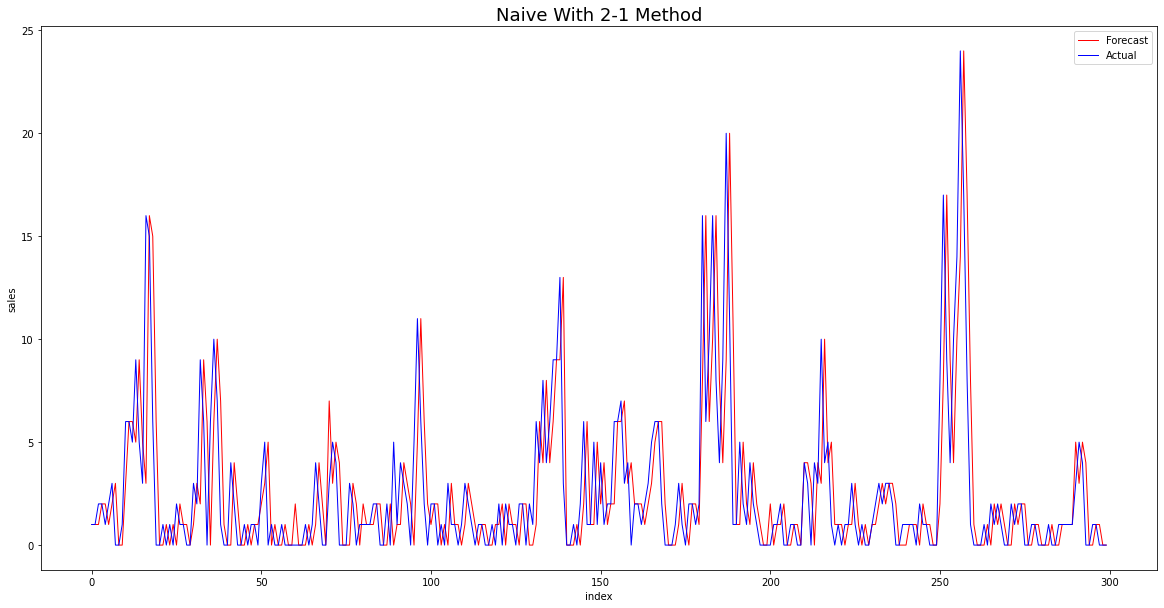

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Naive With 2-1 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# Naive Method 4-1

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
    # Naive method train_window = 4
    # SO-fore2-1 with --method=naive and --use_teacher_forcing=1
    args.new_window = True
    args.use_teacher_forcing = 1
    gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-66a88f88-4085-4b12-be1f-4f0f567d5d89.json', method='naive', new_window=True, seed=21, trend_len=52, use_teacher_forcing=1)
Loading dataset...
Done.
Test batches: 84


100%|██████████| 84/84 [04:41<00:00,  3.36s/it]

Results for naive
105.113,1.093999981880188


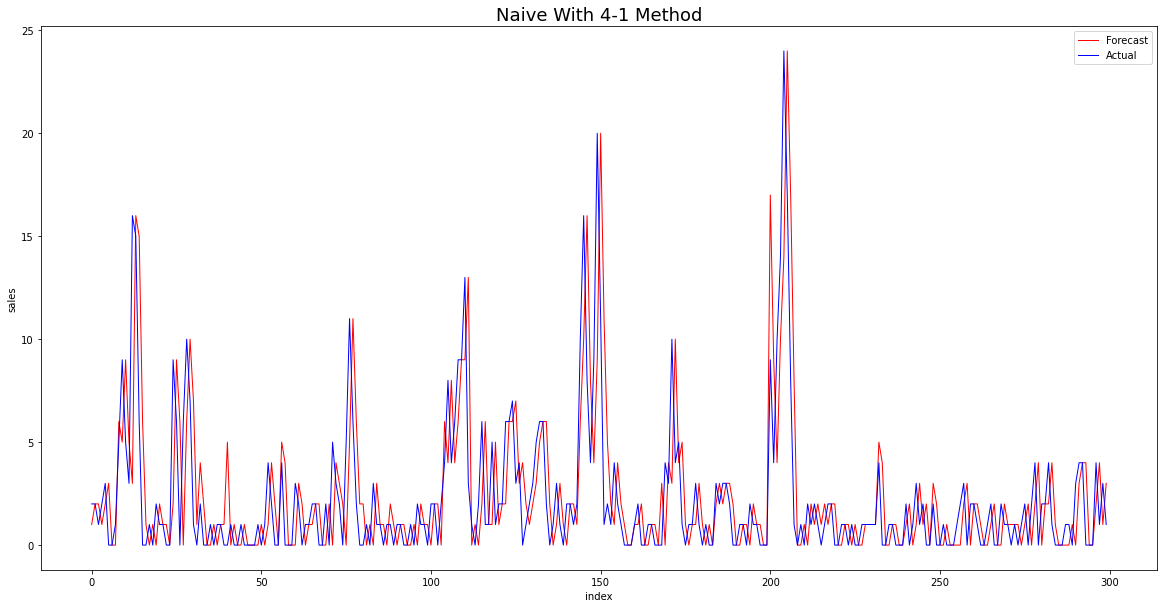

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Naive With 4-1 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# Naive Method 2-10

In [ ]:
# Naive method
# SO-fore2-10 with --method=naive and --use_teacher_forcing=0
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.method = "naive"
  args.use_teacher_forcing = 0
  args.new_window = False
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-66a88f88-4085-4b12-be1f-4f0f567d5d89.json', method='naive', new_window=False, seed=21, trend_len=52, use_teacher_forcing=0)
Loading dataset...
Done.
Test batches: 84


100%|██████████| 84/84 [04:40<00:00,  3.34s/it]

Results for naive
117.48,1.3040000200271606


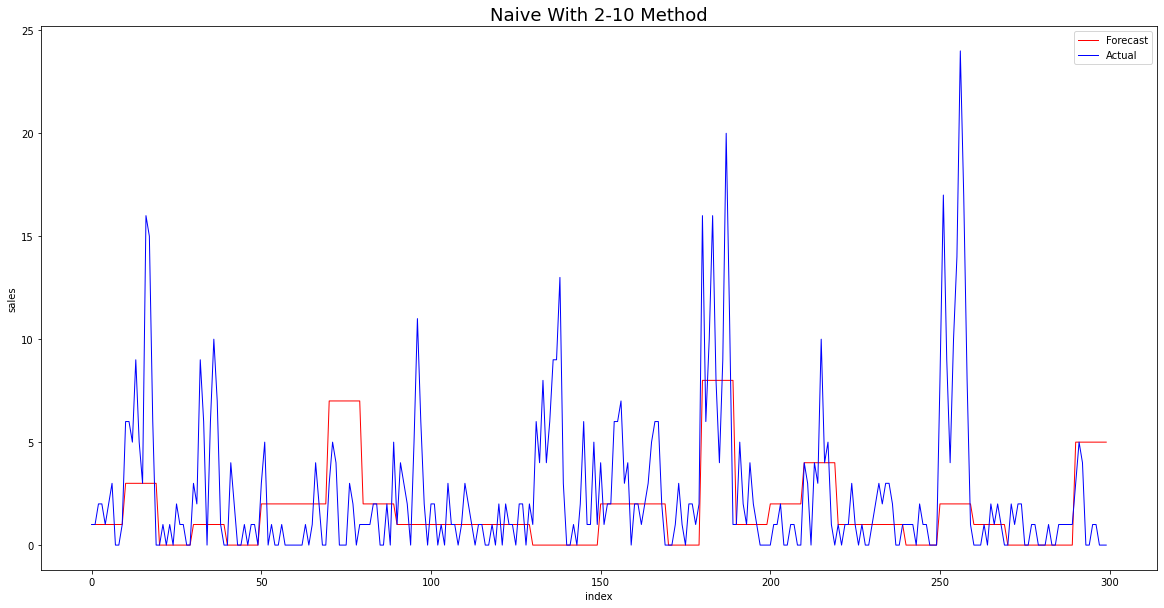

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Naive With 2-10 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# Naive Method 4-8

In [ ]:
# Naive method train_window = 4
# SO-fore2-10 with --method=naive and --use_teacher_forcing=0
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.method = "naive"
  args.new_window = True
  args.use_teacher_forcing = 0
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-66a88f88-4085-4b12-be1f-4f0f567d5d89.json', method='naive', new_window=True, seed=21, trend_len=52, use_teacher_forcing=0)
Loading dataset...
Done.
Test batches: 84


100%|██████████| 84/84 [04:56<00:00,  3.52s/it]

Results for naive
132.744,1.38100004196167


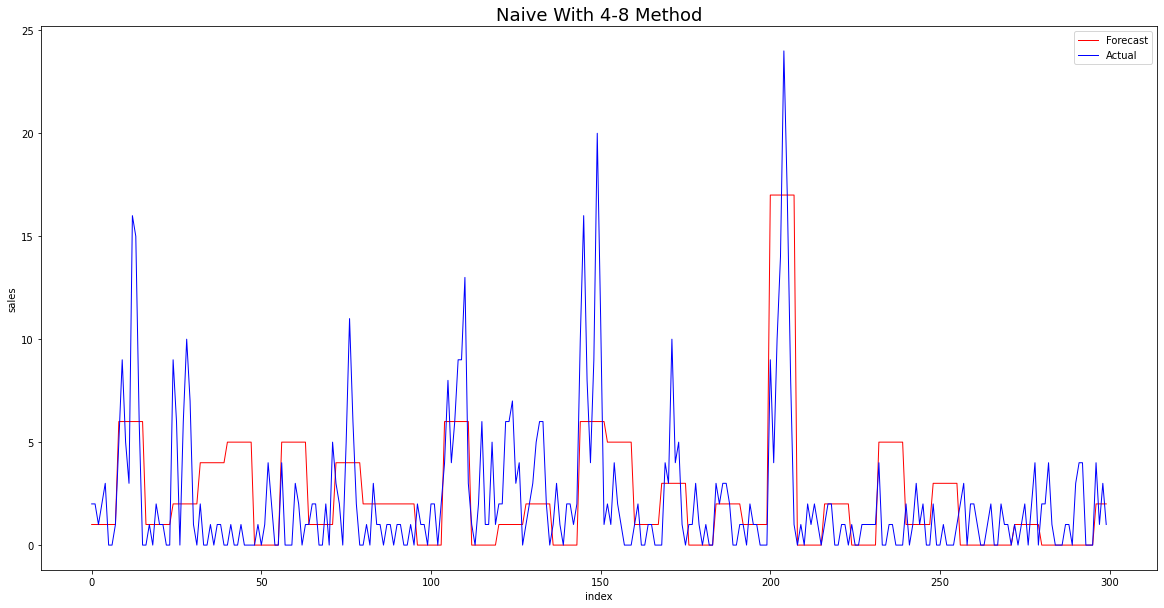

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Naive With 4-8 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# Simple Exponential Smoothing Method 2-1

In [ ]:
# Simple Exponential Smoothing Method
# SO-fore2-1 with --method=ses and --use_teacher_forcing=1
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.method = "ses"
  args.use_teacher_forcing = 1
  args.new_window = False
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-66a88f88-4085-4b12-be1f-4f0f567d5d89.json', method='ses', new_window=False, seed=21, trend_len=52, use_teacher_forcing=1)
Loading dataset...
Done.
Test batches: 84


  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
100%|██████████| 84/84 [09:22<00:00,  6.70s/it]

Results for ses
97.053,1.077


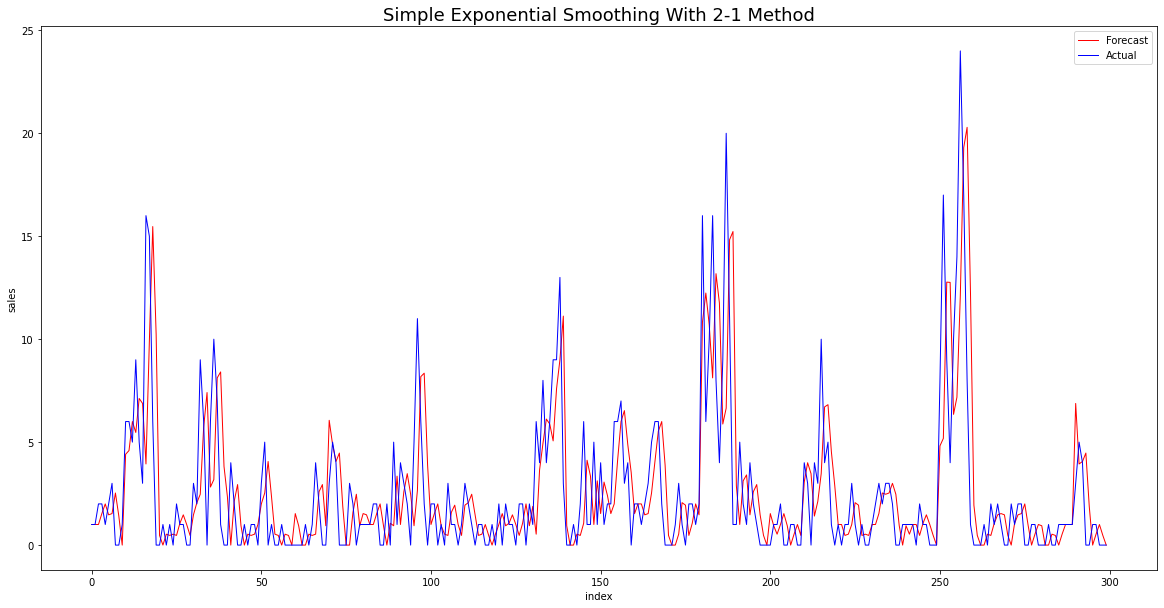

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Simple Exponential Smoothing With 2-1 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# Simple Exponential Smoothing Method 4-1

In [ ]:
# Simple Exponential Smoothing Method train_window=4
# SO-fore2-1 with --method=ses and --use_teacher_forcing=1
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.method = "ses"
  args.new_window = True
  args.use_teacher_forcing = 1
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-773ac1ef-9b11-434e-b81d-2c1c6cf1829c.json', method='ses', new_window=True, seed=21, trend_len=52, use_teacher_forcing=1)
Loading dataset...
Done.
Test batches: 84


  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
100%|██████████| 84/84 [14:11<00:00, 10.13s/it]


Results for ses
102.734,1.069


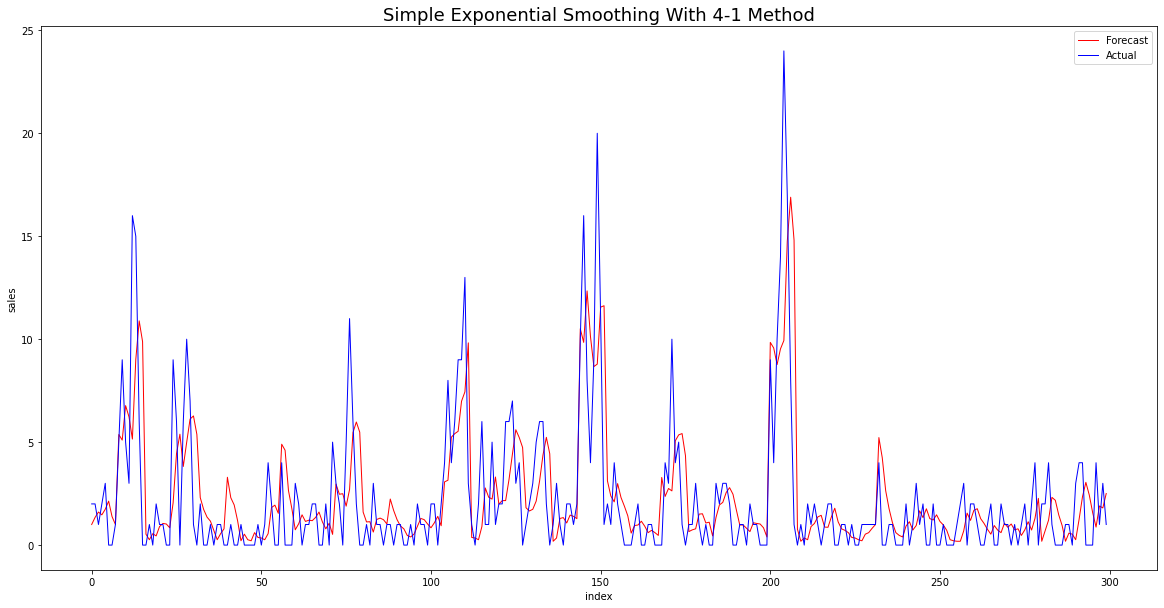

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Simple Exponential Smoothing With 4-1 Method', fontsize=18)
pyplot.legend()
pyplot.show()

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
df

,Actual,Forecast
0,2.0,1.000000
1,2.0,1.344570
2,1.0,1.604871
3,2.0,1.469799
4,3.0,1.739699
...,...,...
85467,0.0,0.655430
85468,0.0,0.395129
85469,1.0,0.185631
85470,0.0,0.344570


# Simple Exponential Smoothing Method 2-10

In [ ]:
# Simple Exponential Smoothing Method
# SO-fore2-10 with --method=ses and --use_teacher_forcing=0
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.method = "ses"
  args.use_teacher_forcing = 0
  args.new_window = False
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-66a88f88-4085-4b12-be1f-4f0f567d5d89.json', method='ses', new_window=False, seed=21, trend_len=52, use_teacher_forcing=0)
Loading dataset...
Done.
Test batches: 84


  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
100%|██████████| 84/84 [05:15<00:00,  3.76s/it]

Results for ses
110.627,1.228


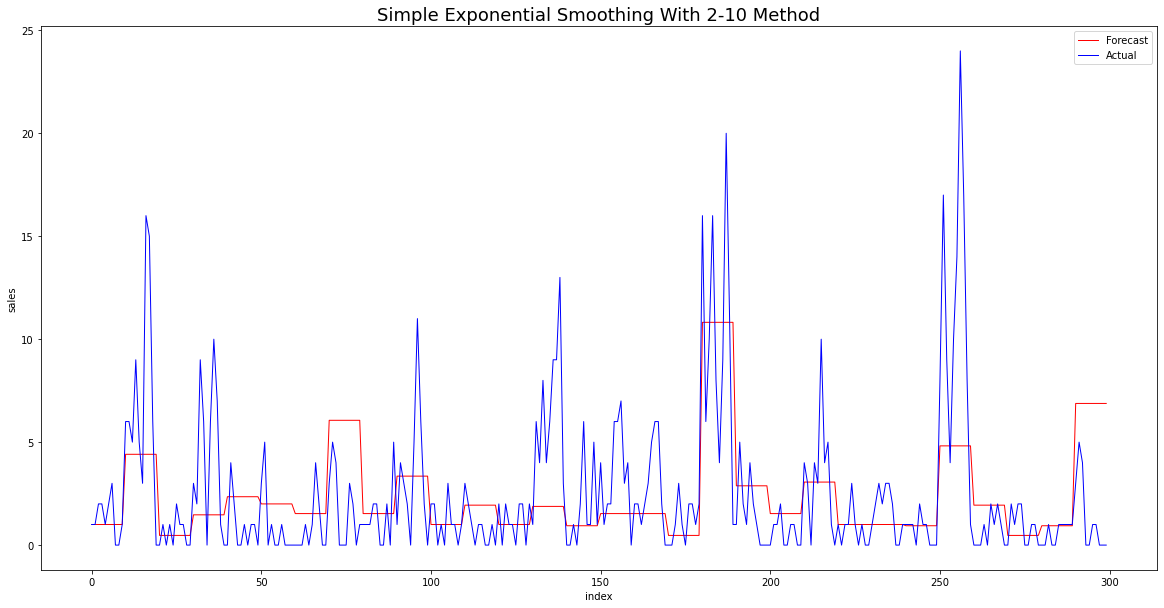

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Simple Exponential Smoothing With 2-10 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# Simple Exponential Smoothing Method 4-8

In [ ]:
# Simple Exponential Smoothing Method train_window = 4
# SO-fore2-10 with --method=ses and --use_teacher_forcing=0
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.method = "ses"
  args.new_window = True
  args.use_teacher_forcing = 0
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(batch_size=128, dataset_path='visuelle2/', f='/root/.local/share/jupyter/runtime/kernel-66a88f88-4085-4b12-be1f-4f0f567d5d89.json', method='ses', new_window=True, seed=21, trend_len=52, use_teacher_forcing=0)
Loading dataset...
Done.
Test batches: 84


  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
100%|██████████| 84/84 [05:31<00:00,  3.94s/it]

Results for ses
116.864,1.216


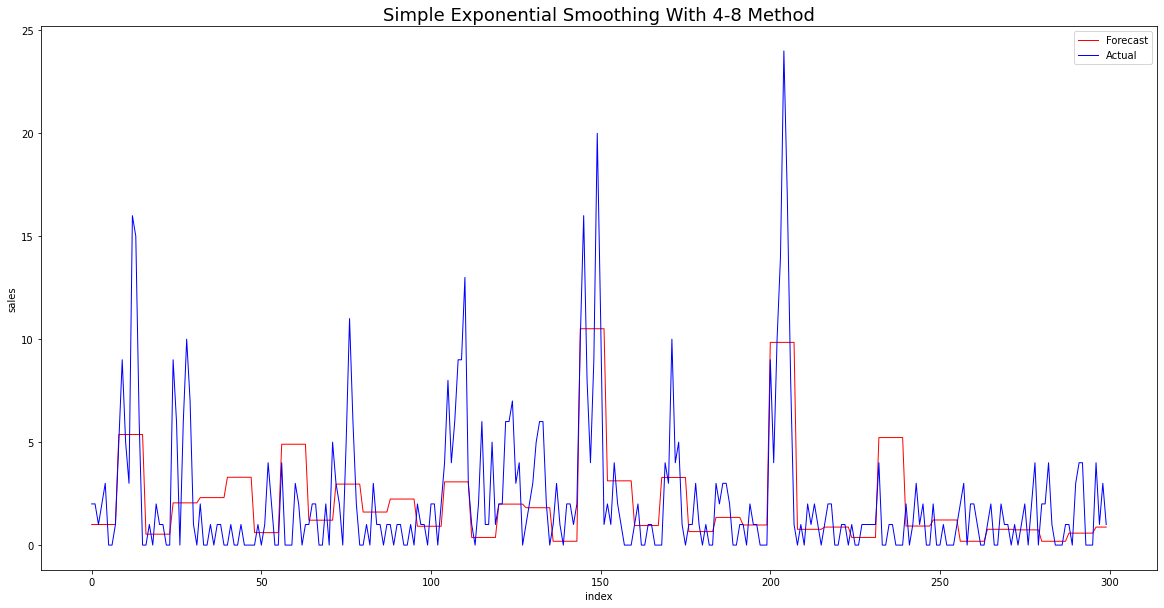

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Simple Exponential Smoothing With 4-8 Method', fontsize=18)
pyplot.legend()
pyplot.show()

## Preprocesing data
---------------------------------------------------

-----------------------------

# Testset

In [ ]:
test_df = pd.read_csv(
        os.path.join(args.dataset_path, "stfore_test.csv"),
        parse_dates=["release_date"],
    )

In [ ]:
test_df.isnull().sum()

external_code    0
retail           0
season           0
category         0
color            0
image_path       0
fabric           0
release_date     0
restock          0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
7                0
8                0
9                0
10               0
11               0
dtype: int64

In [ ]:
pd.isna(test_df.values).sum()

0

In [ ]:
test_df[test_df.iloc[:,-12:] < 0].iloc[:,-12:].count()

0       0
1       0
2       0
3       0
4     141
5     164
6       0
7       0
8       0
9      67
10     50
11      0
dtype: int64

In [ ]:
test_df_clean = test_df.copy()
test_df_clean.iloc[:,-12:] = test_df_clean.iloc[:,-12:].clip(lower=0)
test_df_clean[test_df_clean.iloc[:,-12:] < 0].iloc[:,-12:].count()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
dtype: int64

In [ ]:
df[df['Actual']<0]['Actual']

237     -1.0
254     -1.0
345     -1.0
478     -1.0
897     -1.0
        ... 
84757   -1.0
84896   -1.0
85005   -1.0
85032   -1.0
85352   -1.0
Name: Actual, Length: 422, dtype: float32

# Trainset

In [ ]:
train_df = pd.read_csv(
        os.path.join(args.dataset_path, "stfore_train.csv"),
        parse_dates=["release_date"],
    )
train_df

,external_code,retail,season,category,color,image_path,fabric,release_date,restock,0,...,2,3,4,5,6,7,8,9,10,11
0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,0.415094,0.018868,...,0.018868,0.018868,0.037736,0.018868,0.000000,0.000000,0.037736,0.000000,0.000000,0.000000
1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,0.320755,0.018868,...,0.018868,0.000000,0.000000,0.037736,0.000000,0.000000,0.000000,0.018868,0.018868,0.000000
2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,0.283019,0.018868,...,0.018868,0.000000,0.018868,0.018868,0.018868,0.018868,0.018868,0.000000,0.000000,0.018868
3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,0.603774,0.018868,...,0.018868,0.018868,0.000000,0.000000,0.000000,0.018868,0.000000,0.018868,0.000000,0.000000
4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,0.490566,0.018868,...,0.075472,0.000000,0.056604,0.000000,0.037736,0.018868,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96161,5444,3,AW19,long sleeve,black,AI19/05444.png,georgette,2019-11-11,0.226415,0.037736,...,0.037736,0.000000,0.000000,0.018868,0.037736,0.037736,0.000000,0.037736,0.000000,0.000000
96162,5005,61,AW19,short sleeves,white,AI19/05005.png,nice,2019-11-11,0.132075,0.018868,...,0.000000,0.000000,0.000000,0.018868,0.018868,0.056604,0.000000,-0.018868,0.000000,0.000000
96163,5365,42,AW19,culottes,blue,AI19/05365.png,dark jeans,2019-11-11,0.169811,0.037736,...,0.037736,0.000000,0.018868,0.018868,0.000000,0.000000,0.000000,0.018868,0.018868,0.000000
96164,5005,28,AW19,short sleeves,white,AI19/05005.png,nice,2019-11-11,0.169811,0.018868,...,0.000000,0.018868,0.000000,0.037736,0.000000,0.000000,0.018868,0.018868,0.000000,0.000000


In [ ]:
train_df.isnull().sum()

external_code    0
retail           0
season           0
category         0
color            0
image_path       0
fabric           0
release_date     0
restock          0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
7                0
8                0
9                0
10               0
11               0
dtype: int64

In [ ]:
pd.isna(train_df.values).sum()

0

In [ ]:
train_df[train_df.iloc[:,-12:] < 0].iloc[:,-12:].count()

0       0
1       0
2       0
3       0
4     752
5     797
6       0
7       0
8       0
9     737
10    678
11      0
dtype: int64

In [ ]:
train_df_clean = train_df.copy()
train_df_clean.iloc[:,-12:] = train_df_clean.iloc[:,-12:].clip(lower=0)
train_df_clean[train_df_clean.iloc[:,-12:] < 0].iloc[:,-12:].count()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
dtype: int64

# Full sales dataset

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
sales_df = pd.read_csv(
        os.path.join(args.dataset_path, "sales.csv"),
        parse_dates=["release_date"]
    )
sales_df.drop(sales_df.columns[[0]], axis=1, inplace=True)

In [ ]:
sales_df

,external_code,retail,season,category,color,image_path,fabric,release_date,restock,0,...,2,3,4,5,6,7,8,9,10,11
0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,1.0,...,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,1.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,1.0,...,4.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106845,5504,51,AW19,medium coat,grey,AI19/05504.png,foam rubber,2019-12-30,12,2.0,...,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
106846,5558,10,AW19,medium coat,black,AI19/05558.png,foam rubber,2019-12-30,12,3.0,...,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0
106847,4988,108,AW19,medium coat,black,AI19/04988.png,cloth,2019-12-30,15,1.0,...,0.0,1.0,2.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0
106848,4280,105,AW19,culottes,blue,AI19/04280.png,light jeans,2019-12-30,1,1.0,...,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sales_df.isnull().sum()

external_code    0
retail           0
season           0
category         0
color            0
image_path       0
fabric           0
release_date     0
restock          0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
7                0
8                0
9                0
10               0
11               0
dtype: int64

In [ ]:
pd.isna(sales_df.values).sum()

0

In [ ]:
sales_group = ['0','1','2','3','4','5','6','7','8','9','10','11']

In [ ]:
stock_df = pd.read_csv(
        os.path.join(args.dataset_path, "restocks.csv")
    )
stock_df

,external_code,retail,week,year,qty
0,3642,30,50,2018,5
1,3642,30,51,2018,6
2,3642,30,1,2019,2
3,3642,30,2,2019,3
4,3642,30,4,2019,4
...,...,...,...,...,...
949761,5073,64,2,2020,2
949762,5073,41,42,2019,7
949763,5073,41,45,2019,2
949764,5073,23,42,2019,5


# Visulization dataset 
-----------------------------------------------------

# Sum of sales by category

In [ ]:
category_sales_df = sales_df.groupby(['category'])[sales_group].sum()
category_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11
category,,,,,,,,,,,,
capris,1162.0,813.0,1021.0,1018.0,1072.0,1364.0,1340.0,1044.0,911.0,685.0,478.0,376.0
culottes,36273.0,29434.0,28168.0,27962.0,27989.0,28069.0,27288.0,24891.0,21345.0,17775.0,15406.0,13608.0
doll dress,17796.0,16299.0,15142.0,14634.0,13734.0,12909.0,11965.0,10685.0,9431.0,8099.0,6867.0,6433.0
drop sleeve,5734.0,4787.0,4776.0,4962.0,5026.0,4873.0,4823.0,4155.0,3451.0,2844.0,2490.0,2081.0
gitana skirt,1179.0,932.0,991.0,959.0,964.0,988.0,932.0,953.0,826.0,720.0,659.0,579.0
jumpsuit,2925.0,2356.0,2228.0,2192.0,2282.0,2462.0,2565.0,2203.0,1819.0,1583.0,1098.0,730.0
kimono dress,8594.0,7076.0,8319.0,8496.0,8104.0,8258.0,7563.0,6339.0,5883.0,5230.0,4812.0,4060.0
long cardigan,503.0,350.0,332.0,358.0,319.0,292.0,330.0,340.0,270.0,217.0,215.0,196.0
long coat,4265.0,3160.0,3269.0,3619.0,3419.0,3423.0,3048.0,2857.0,2432.0,2171.0,1880.0,1626.0


In [ ]:
category_sales_df['sum_of_sales'] = category_sales_df.iloc[:,0:11].sum(axis=1)
category_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11,sum_of_sales
category,,,,,,,,,,,,,
capris,1162.0,813.0,1021.0,1018.0,1072.0,1364.0,1340.0,1044.0,911.0,685.0,478.0,376.0,10908.0
culottes,36273.0,29434.0,28168.0,27962.0,27989.0,28069.0,27288.0,24891.0,21345.0,17775.0,15406.0,13608.0,284600.0
doll dress,17796.0,16299.0,15142.0,14634.0,13734.0,12909.0,11965.0,10685.0,9431.0,8099.0,6867.0,6433.0,137561.0
drop sleeve,5734.0,4787.0,4776.0,4962.0,5026.0,4873.0,4823.0,4155.0,3451.0,2844.0,2490.0,2081.0,47921.0
gitana skirt,1179.0,932.0,991.0,959.0,964.0,988.0,932.0,953.0,826.0,720.0,659.0,579.0,10103.0
jumpsuit,2925.0,2356.0,2228.0,2192.0,2282.0,2462.0,2565.0,2203.0,1819.0,1583.0,1098.0,730.0,23713.0
kimono dress,8594.0,7076.0,8319.0,8496.0,8104.0,8258.0,7563.0,6339.0,5883.0,5230.0,4812.0,4060.0,78674.0
long cardigan,503.0,350.0,332.0,358.0,319.0,292.0,330.0,340.0,270.0,217.0,215.0,196.0,3526.0
long coat,4265.0,3160.0,3269.0,3619.0,3419.0,3423.0,3048.0,2857.0,2432.0,2171.0,1880.0,1626.0,33543.0


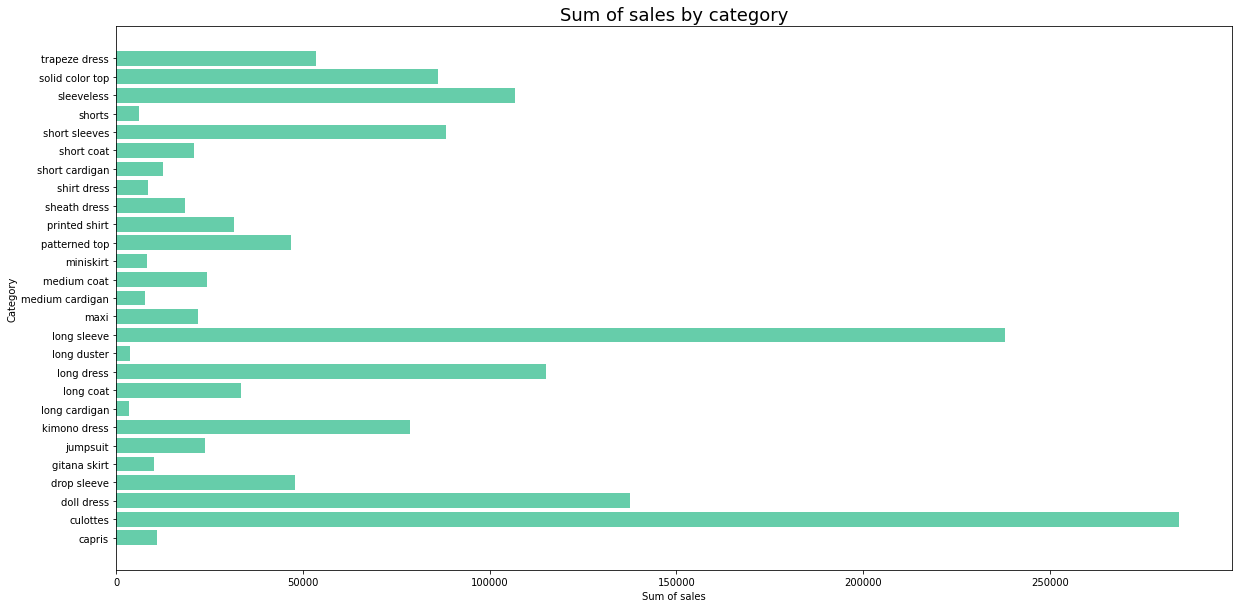

In [ ]:
plt.figure(figsize=(20, 10))
plt.barh(category_sales_df.index, category_sales_df['sum_of_sales'], color='mediumaquamarine')
plt.title('Sum of sales by category', fontsize=18)
plt.xlabel('Sum of sales')
plt.ylabel('Category')
plt.show()

# Sum of sales by color

In [ ]:
color_sales_df = sales_df.groupby(['color'])[sales_group].sum()
color_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11
color,,,,,,,,,,,,
black,85221.0,70410.0,68629.0,70311.0,68254.0,66427.0,62573.0,56143.0,49635.0,42398.0,35932.0,30560.0
blue,16678.0,13508.0,12845.0,12299.0,12440.0,12121.0,11313.0,10425.0,9016.0,7628.0,6504.0,5093.0
brown,18048.0,14295.0,14419.0,14107.0,14199.0,14306.0,13637.0,11899.0,10147.0,8315.0,7223.0,6016.0
green,10937.0,8780.0,8503.0,8303.0,8429.0,8664.0,8705.0,7953.0,6522.0,5488.0,4476.0,3694.0
grey,16621.0,14508.0,14129.0,14288.0,13572.0,13809.0,13009.0,11364.0,9433.0,7861.0,6553.0,5420.0
orange,728.0,648.0,678.0,650.0,704.0,969.0,996.0,639.0,403.0,278.0,155.0,106.0
red,7713.0,6377.0,5817.0,5675.0,5410.0,5202.0,4781.0,4239.0,3737.0,3075.0,2576.0,2050.0
violet,14323.0,11922.0,10979.0,10908.0,10335.0,10072.0,9730.0,8620.0,7944.0,6902.0,6291.0,5815.0
white,19136.0,15381.0,14511.0,14797.0,14698.0,14999.0,14985.0,13567.0,12410.0,11430.0,10120.0,9160.0


In [ ]:
color_sales_df['sum_of_sales'] = color_sales_df.iloc[:,0:11].sum(axis=1)
color_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11,sum_of_sales
color,,,,,,,,,,,,,
black,85221.0,70410.0,68629.0,70311.0,68254.0,66427.0,62573.0,56143.0,49635.0,42398.0,35932.0,30560.0,675933.0
blue,16678.0,13508.0,12845.0,12299.0,12440.0,12121.0,11313.0,10425.0,9016.0,7628.0,6504.0,5093.0,124777.0
brown,18048.0,14295.0,14419.0,14107.0,14199.0,14306.0,13637.0,11899.0,10147.0,8315.0,7223.0,6016.0,140595.0
green,10937.0,8780.0,8503.0,8303.0,8429.0,8664.0,8705.0,7953.0,6522.0,5488.0,4476.0,3694.0,86760.0
grey,16621.0,14508.0,14129.0,14288.0,13572.0,13809.0,13009.0,11364.0,9433.0,7861.0,6553.0,5420.0,135147.0
orange,728.0,648.0,678.0,650.0,704.0,969.0,996.0,639.0,403.0,278.0,155.0,106.0,6848.0
red,7713.0,6377.0,5817.0,5675.0,5410.0,5202.0,4781.0,4239.0,3737.0,3075.0,2576.0,2050.0,54602.0
violet,14323.0,11922.0,10979.0,10908.0,10335.0,10072.0,9730.0,8620.0,7944.0,6902.0,6291.0,5815.0,108026.0
white,19136.0,15381.0,14511.0,14797.0,14698.0,14999.0,14985.0,13567.0,12410.0,11430.0,10120.0,9160.0,156034.0


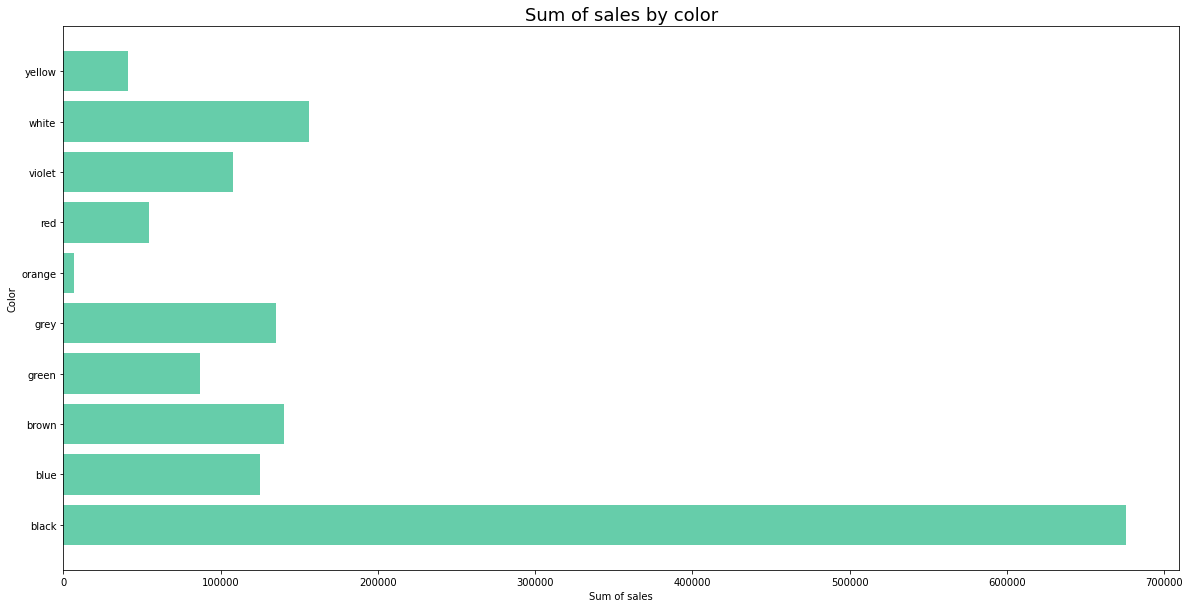

In [ ]:
plt.figure(figsize=(20, 10))
plt.barh(color_sales_df.index, color_sales_df['sum_of_sales'], color='mediumaquamarine')
plt.title('Sum of sales by color', fontsize=18)
plt.xlabel('Sum of sales')
plt.ylabel('Color')
plt.show()

# Sum of sales by fabric

In [ ]:
fabric_sales_df = sales_df.groupby(['fabric'])[sales_group].sum()
fabric_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11
fabric,,,,,,,,,,,,
acrylic,8714.0,7337.0,7584.0,7560.0,7370.0,8002.0,7591.0,6615.0,6640.0,5837.0,4862.0,3922.0
angora,96.0,64.0,63.0,46.0,72.0,52.0,61.0,74.0,55.0,24.0,15.0,8.0
bengaline,5778.0,4859.0,5157.0,5332.0,5283.0,5387.0,5509.0,5070.0,4402.0,3768.0,3393.0,3328.0
cady,1213.0,1055.0,1001.0,1016.0,841.0,817.0,762.0,645.0,512.0,350.0,268.0,275.0
chambree,539.0,387.0,441.0,432.0,586.0,761.0,760.0,608.0,481.0,470.0,385.0,319.0
chanel,9.0,1.0,5.0,4.0,7.0,9.0,6.0,3.0,5.0,4.0,1.0,0.0
chine crepe,304.0,157.0,157.0,185.0,200.0,221.0,234.0,232.0,226.0,219.0,158.0,139.0
cloth,2768.0,2057.0,2152.0,2177.0,2110.0,2240.0,2064.0,2051.0,1919.0,1657.0,1360.0,1274.0
cotton,10913.0,8868.0,8405.0,8358.0,8187.0,8046.0,7642.0,6357.0,5365.0,4729.0,4363.0,3481.0


In [ ]:
fabric_sales_df['sum_of_sales'] = fabric_sales_df.iloc[:,0:11].sum(axis=1)
fabric_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11,sum_of_sales
fabric,,,,,,,,,,,,,
acrylic,8714.0,7337.0,7584.0,7560.0,7370.0,8002.0,7591.0,6615.0,6640.0,5837.0,4862.0,3922.0,78112.0
angora,96.0,64.0,63.0,46.0,72.0,52.0,61.0,74.0,55.0,24.0,15.0,8.0,622.0
bengaline,5778.0,4859.0,5157.0,5332.0,5283.0,5387.0,5509.0,5070.0,4402.0,3768.0,3393.0,3328.0,53938.0
cady,1213.0,1055.0,1001.0,1016.0,841.0,817.0,762.0,645.0,512.0,350.0,268.0,275.0,8480.0
chambree,539.0,387.0,441.0,432.0,586.0,761.0,760.0,608.0,481.0,470.0,385.0,319.0,5850.0
chanel,9.0,1.0,5.0,4.0,7.0,9.0,6.0,3.0,5.0,4.0,1.0,0.0,54.0
chine crepe,304.0,157.0,157.0,185.0,200.0,221.0,234.0,232.0,226.0,219.0,158.0,139.0,2293.0
cloth,2768.0,2057.0,2152.0,2177.0,2110.0,2240.0,2064.0,2051.0,1919.0,1657.0,1360.0,1274.0,22555.0
cotton,10913.0,8868.0,8405.0,8358.0,8187.0,8046.0,7642.0,6357.0,5365.0,4729.0,4363.0,3481.0,81233.0


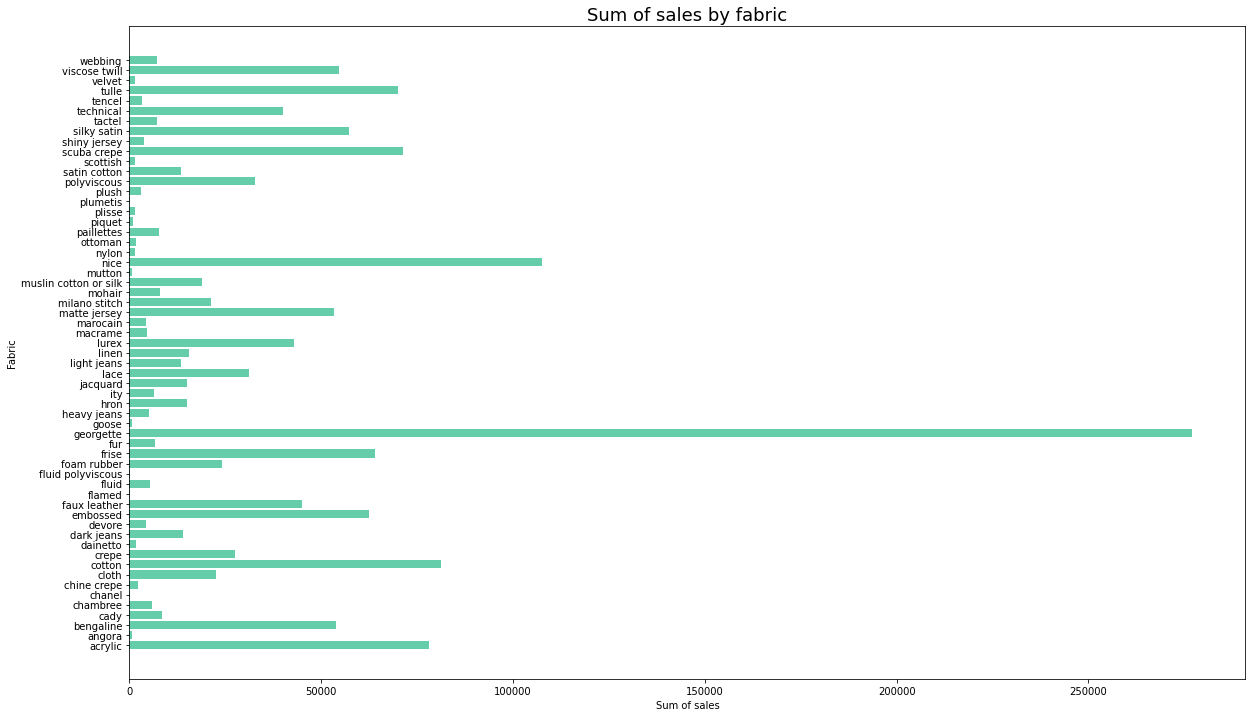

In [ ]:
plt.figure(figsize=(20, 12))
plt.barh(fabric_sales_df.index, fabric_sales_df['sum_of_sales'], color='mediumaquamarine')
plt.title('Sum of sales by fabric', fontsize=18)
plt.xlabel('Sum of sales')
plt.ylabel('Fabric')
plt.show()

# Sum of sales by season

In [ ]:
season_sales_df = sales_df.groupby(['season'])[sales_group].sum()
season_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11
season,,,,,,,,,,,,
AW17,30296.0,25814.0,24702.0,24651.0,24158.0,22942.0,21234.0,18923.0,16696.0,13457.0,11538.0,9532.0
AW18,33460.0,28244.0,26377.0,27271.0,26110.0,24582.0,21969.0,19750.0,17521.0,14584.0,12433.0,10366.0
AW19,43813.0,35200.0,35104.0,35257.0,32815.0,32422.0,29781.0,25426.0,21340.0,18521.0,14907.0,12774.0
SS17,21581.0,16669.0,17162.0,16991.0,18143.0,19948.0,20568.0,18456.0,15416.0,12156.0,9620.0,8010.0
SS18,29921.0,24347.0,22823.0,22700.0,22888.0,23038.0,22848.0,21058.0,19741.0,17558.0,15643.0,13561.0
SS19,35970.0,30048.0,28554.0,28742.0,28022.0,27717.0,27184.0,24657.0,21555.0,19369.0,17387.0,15079.0


In [ ]:
season_sales_df['sum_of_sales'] = season_sales_df.iloc[:,0:11].sum(axis=1)
season_sales_df

,0,1,2,3,4,5,6,7,8,9,10,11,sum_of_sales
season,,,,,,,,,,,,,
AW17,30296.0,25814.0,24702.0,24651.0,24158.0,22942.0,21234.0,18923.0,16696.0,13457.0,11538.0,9532.0,234411.0
AW18,33460.0,28244.0,26377.0,27271.0,26110.0,24582.0,21969.0,19750.0,17521.0,14584.0,12433.0,10366.0,252301.0
AW19,43813.0,35200.0,35104.0,35257.0,32815.0,32422.0,29781.0,25426.0,21340.0,18521.0,14907.0,12774.0,324586.0
SS17,21581.0,16669.0,17162.0,16991.0,18143.0,19948.0,20568.0,18456.0,15416.0,12156.0,9620.0,8010.0,186710.0
SS18,29921.0,24347.0,22823.0,22700.0,22888.0,23038.0,22848.0,21058.0,19741.0,17558.0,15643.0,13561.0,242565.0
SS19,35970.0,30048.0,28554.0,28742.0,28022.0,27717.0,27184.0,24657.0,21555.0,19369.0,17387.0,15079.0,289205.0


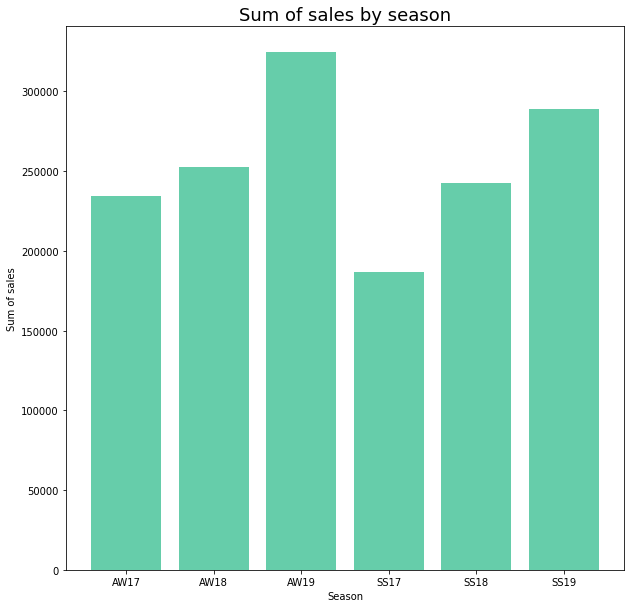

In [ ]:
plt.figure(figsize=(10, 10))
plt.bar(season_sales_df.index, season_sales_df['sum_of_sales'], color='mediumaquamarine')
plt.title('Sum of sales by season', fontsize=18)
plt.ylabel('Sum of sales')
plt.xlabel('Season')
plt.show()

# Sum of sales and restock group by external code

In [ ]:
sales_group = ['0','1','2','3','4','5','6','7','8','9','10','11']
sales_group.append('restock')
stock_sales_df = sales_df.groupby('external_code',as_index=False)[sales_group].sum()

In [ ]:
stock_sales_df['sum_of_sales'] = stock_sales_df.iloc[:,0:11].sum(axis=1)
stock_sales_df[stock_sales_df['external_code']==3540]

,external_code,0,1,2,3,4,5,6,7,8,9,10,11,restock,sum_of_sales
3400,3540,46.0,33.0,50.0,47.0,39.0,22.0,15.0,20.0,20.0,18.0,11.0,11.0,426,3850.0


In [ ]:
top_stock_sales_df = stock_sales_df.sort_values('sum_of_sales', ascending=False).iloc[:30,:]
top_stock_sales_df = top_stock_sales_df.sort_values('external_code', ascending=True)
top_stock_sales_df['external_code'] = top_stock_sales_df['external_code'].apply(str)

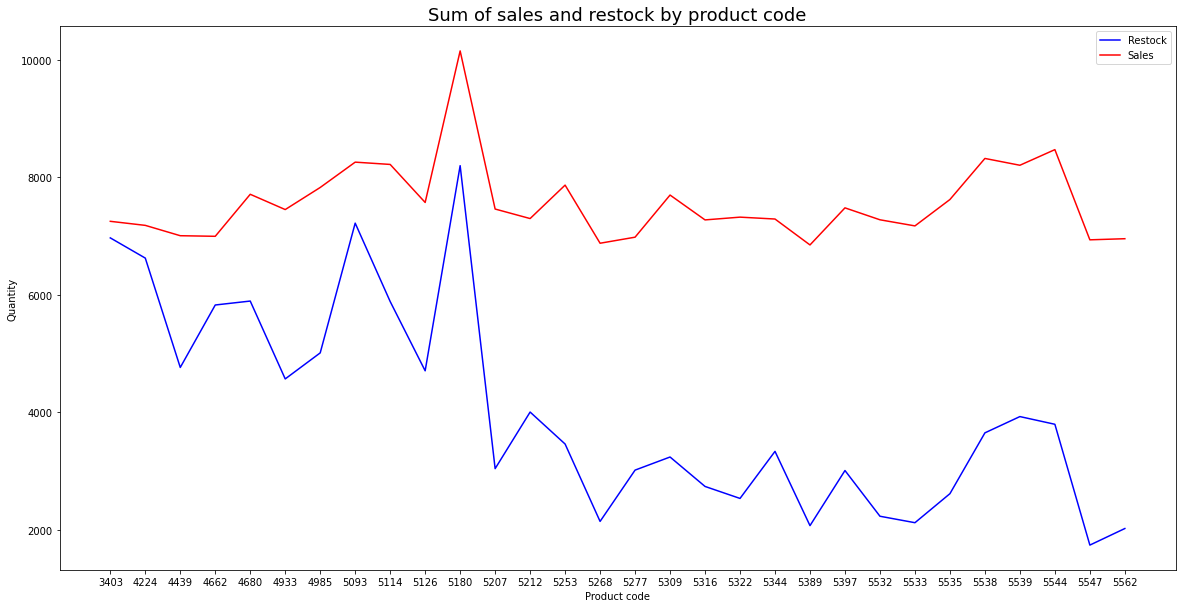

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(top_stock_sales_df['external_code'], top_stock_sales_df['restock'], color='blue', label='Restock')
plt.plot(top_stock_sales_df['external_code'], top_stock_sales_df['sum_of_sales'], color='red', label='Sales')
plt.title('Sum of sales and restock by product code', fontsize=18)
plt.ylabel('Quantity')
plt.xlabel('Product code')
plt.legend()
plt.show()

# Google trend of top 5 products best sold in season AW19

In [ ]:
from pandas.api.types import is_numeric_dtype

In [ ]:
top_products_AW19_df = sales_df[sales_df['season']=='AW19'].groupby('external_code').agg(lambda x: x.sum() if is_numeric_dtype(x) else x.unique())
top_products_AW19_df

,retail,season,category,color,image_path,fabric,restock,0,1,2,3,4,5,6,7,8,9,10,11
external_code,,,,,,,,,,,,,,,,,,,
3909,1972,AW19,long sleeve,black,AI19/03909.png,georgette,637,58.0,49.0,46.0,55.0,42.0,36.0,16.0,19.0,27.0,18.0,15.0,17.0
4245,687,AW19,sleeveless,white,AI19/04245.png,frise,135,15.0,16.0,13.0,10.0,17.0,7.0,3.0,5.0,6.0,4.0,6.0,4.0
4246,1210,AW19,patterned top,black,AI19/04246.png,tulle,371,50.0,44.0,29.0,27.0,20.0,28.0,12.0,19.0,20.0,20.0,12.0,8.0
4247,1819,AW19,patterned top,yellow,AI19/04247.png,silky satin,528,57.0,49.0,40.0,26.0,32.0,30.0,28.0,28.0,28.0,33.0,20.0,11.0
4248,1059,AW19,culottes,black,AI19/04248.png,satin cotton,339,47.0,32.0,36.0,23.0,12.0,20.0,13.0,15.0,12.0,13.0,13.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,2122,AW19,trapeze dress,black,AI19/05573.png,milano stitch,590,73.0,55.0,65.0,92.0,54.0,33.0,22.0,17.0,24.0,19.0,10.0,1.0
5574,2028,AW19,trapeze dress,black,AI19/05574.png,milano stitch,626,83.0,79.0,69.0,73.0,52.0,28.0,31.0,27.0,27.0,11.0,13.0,4.0
5575,2212,AW19,trapeze dress,red,AI19/05575.png,milano stitch,725,150.0,64.0,66.0,78.0,46.0,33.0,36.0,41.0,25.0,24.0,19.0,12.0


In [ ]:
top_products_AW19_df['sum_of_sales'] = top_products_AW19_df.iloc[:,-12:].sum(axis=1)
top_products_AW19_df

,retail,season,category,color,image_path,fabric,restock,0,1,2,3,4,5,6,7,8,9,10,11,sum_of_sales
external_code,,,,,,,,,,,,,,,,,,,,
3909,1972,AW19,long sleeve,black,AI19/03909.png,georgette,637,58.0,49.0,46.0,55.0,42.0,36.0,16.0,19.0,27.0,18.0,15.0,17.0,398.0
4245,687,AW19,sleeveless,white,AI19/04245.png,frise,135,15.0,16.0,13.0,10.0,17.0,7.0,3.0,5.0,6.0,4.0,6.0,4.0,106.0
4246,1210,AW19,patterned top,black,AI19/04246.png,tulle,371,50.0,44.0,29.0,27.0,20.0,28.0,12.0,19.0,20.0,20.0,12.0,8.0,289.0
4247,1819,AW19,patterned top,yellow,AI19/04247.png,silky satin,528,57.0,49.0,40.0,26.0,32.0,30.0,28.0,28.0,28.0,33.0,20.0,11.0,382.0
4248,1059,AW19,culottes,black,AI19/04248.png,satin cotton,339,47.0,32.0,36.0,23.0,12.0,20.0,13.0,15.0,12.0,13.0,13.0,6.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,2122,AW19,trapeze dress,black,AI19/05573.png,milano stitch,590,73.0,55.0,65.0,92.0,54.0,33.0,22.0,17.0,24.0,19.0,10.0,1.0,465.0
5574,2028,AW19,trapeze dress,black,AI19/05574.png,milano stitch,626,83.0,79.0,69.0,73.0,52.0,28.0,31.0,27.0,27.0,11.0,13.0,4.0,497.0
5575,2212,AW19,trapeze dress,red,AI19/05575.png,milano stitch,725,150.0,64.0,66.0,78.0,46.0,33.0,36.0,41.0,25.0,24.0,19.0,12.0,594.0


In [ ]:
top_products_AW19_df = top_products_AW19_df.sort_values('sum_of_sales', ascending=False).iloc[:10,[0,1,2,3,5,-1]]
top_products_AW19_df

,retail,season,category,color,fabric,sum_of_sales
external_code,,,,,,
4680,5422,AW19,doll dress,black,georgette,3546.0
4985,5525,AW19,doll dress,black,georgette,3351.0
4933,5296,AW19,culottes,black,milano stitch,3081.0
5544,5169,AW19,kimono dress,grey,frise,2991.0
5538,5290,AW19,kimono dress,brown,frise,2854.0
5539,4485,AW19,maxi,grey,acrylic,2839.0
4439,3901,AW19,long dress,black,silky satin,2762.0
4662,5205,AW19,culottes,black,technical,2747.0
4377,4529,AW19,long dress,black,georgette,2675.0


# Google trends of random product in AW17 (product 959)
+ color: green
+ category: culottes
+ fabric: embossed
+ release date: 5/29/2017

In [ ]:
gtrends_df = pd.read_csv(
        os.path.join(args.dataset_path, "vis2_gtrends_data.csv"),
        parse_dates=["date"]
    )

In [ ]:
from datetime import timedelta, datetime

In [ ]:
gtrends_product_1 = gtrends_df[['green','culottes','embossed','date']][
    (gtrends_df['date'] < datetime(2017,5,29,0,0,0)) 
    & (gtrends_df['date'] >= (datetime(2017,5,29,0,0,0) - timedelta(days=52*7)))]
gtrends_product_1

,green,culottes,embossed,date
34,77,67.0,68,2016-05-30
35,75,69.0,66,2016-06-06
36,81,65.0,60,2016-06-13
37,73,60.0,76,2016-06-20
38,73,62.0,72,2016-06-27
39,77,58.0,69,2016-07-04
40,77,58.0,62,2016-07-11
41,78,60.0,70,2016-07-18
42,77,63.0,63,2016-07-25
43,87,56.0,64,2016-08-01


# Google trends of random product in AW18 (product 3540)
+ color: black
+ category: jumpsuit
+ fabric: lurex
+ release_date: 11/26/2018

In [ ]:
gtrends_product_2 = gtrends_df[['black','jumpsuit','lurex','date']][
    (gtrends_df['date'] < datetime(2018,11,26,0,0,0)) 
    & (gtrends_df['date'] >= (datetime(2018,11,26,0,0,0)- timedelta(days=52*7)))]
gtrends_product_2

,black,jumpsuit,lurex,date
112,30,82.0,46,2017-11-27
113,26,83.0,58,2017-12-04
114,25,79.0,48,2017-12-11
115,25,73.0,51,2017-12-18
116,28,80.0,35,2017-12-25
117,29,58.0,34,2018-01-01
118,28,53.0,32,2018-01-08
119,27,52.0,18,2018-01-15
120,26,51.0,26,2018-01-22
121,27,51.0,27,2018-01-29


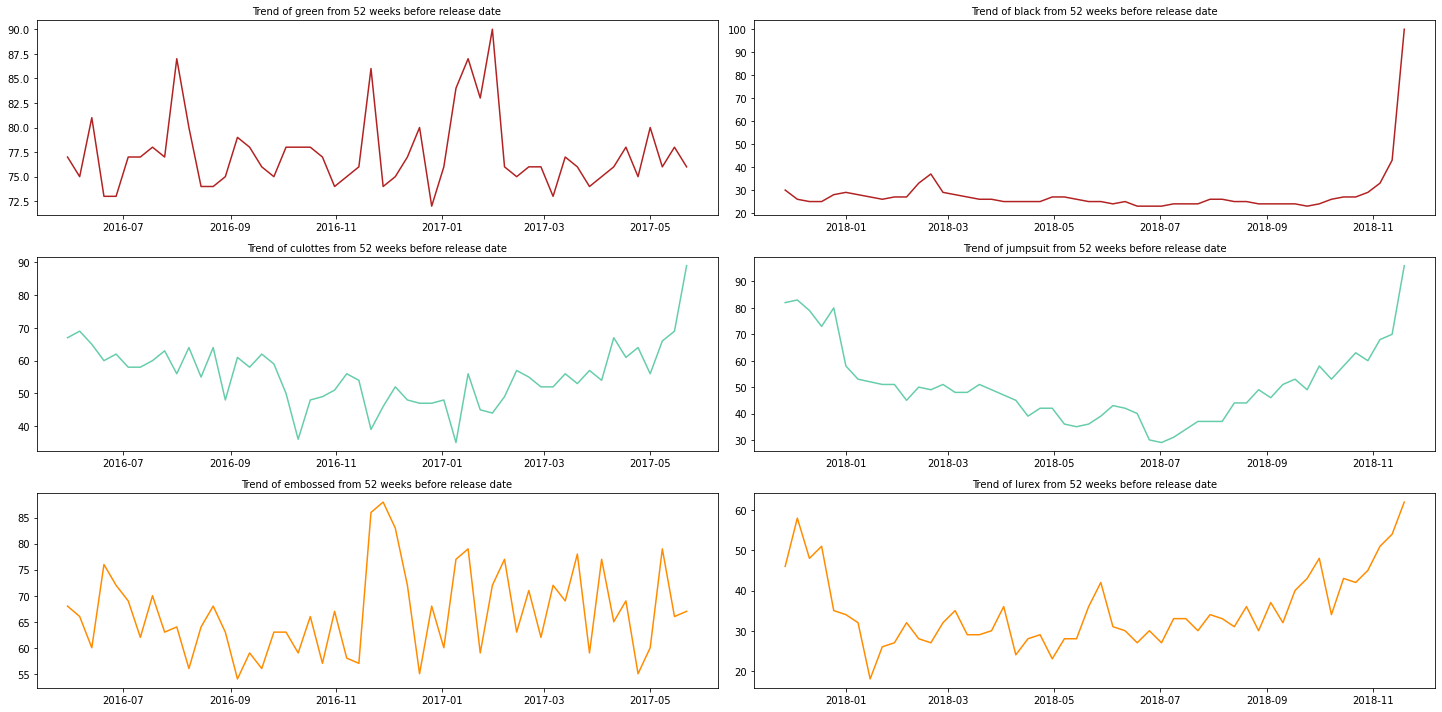

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(20,10))
ax1.plot(gtrends_product_1['date'], gtrends_product_1['green'], color='firebrick', label='Color')
ax1.set_title('Trend of green from 52 weeks before release date', fontsize=10)
ax3.plot(gtrends_product_1['date'], gtrends_product_1['culottes'], color='mediumaquamarine', label='Category')
ax3.set_title('Trend of culottes from 52 weeks before release date', fontsize=10)
ax5.plot(gtrends_product_1['date'], gtrends_product_1['embossed'], color='darkorange', label='Fabric')
ax5.set_title('Trend of embossed from 52 weeks before release date', fontsize=10)

ax2.plot(gtrends_product_2['date'], gtrends_product_2['black'], color='firebrick', label='Color')
ax2.set_title('Trend of black from 52 weeks before release date', fontsize=10)
ax4.plot(gtrends_product_2['date'], gtrends_product_2['jumpsuit'], color='mediumaquamarine', label='Category')
ax4.set_title('Trend of jumpsuit from 52 weeks before release date', fontsize=10)
ax6.plot(gtrends_product_2['date'], gtrends_product_2['lurex'], color='darkorange', label='Fabric')
ax6.set_title('Trend of lurex from 52 weeks before release date', fontsize=10)
fig.tight_layout()
plt.show()
# plt.figure(figsize=(20, 10))
# plt.plot(gtrends_product['date'], gtrends_product['green'], color='blue', label='Green')
# plt.title('Trend of green from 52 weeks before release date', fontsize=18)
# plt.ylabel('Num of search')
# plt.xlabel('Date')
# plt.legend()
# plt.show()

# Top 10 mostly bought by 5 random customers

In [ ]:
customer_df = pd.read_csv(
        os.path.join(args.dataset_path, "customer_data.csv"),
        parse_dates=["data"]
    )

In [ ]:
customer_df = customer_df.groupby(['customer','external_code'], as_index=False)['qty'].sum()
customer_df

,customer,external_code,qty
0,1,718,1
1,1,825,1
2,1,940,1
3,1,2429,1
4,2,427,1
...,...,...,...
987135,645356,1776,1
987136,645556,1758,1
987137,646256,1605,1
987138,646282,1390,1


In [ ]:
customer_count_sales = customer_df.pivot_table(columns=['customer'], aggfunc='size')
customer_count_sales = pd.DataFrame(customer_count_sales,columns=['num_bought_product'])
customer_count_top_sales = customer_count_sales[customer_count_sales['num_bought_product']>=10]
customer_count_top_sales

,num_bought_product
customer,
11,10
20,24
29,16
43,20
47,31
...,...
520823,11
520826,20
520868,12


# Top 10 bought product of 5 random customers (11,20,47,89,187)

In [ ]:
customer1_df = customer_df[customer_df['customer']==11].sort_values('qty',ascending=False)
customer1_df

,customer,external_code,qty
24,11,733,1
25,11,941,1
26,11,1270,1
27,11,1305,1
28,11,1616,1
29,11,1624,1
30,11,1651,1
31,11,1692,1
32,11,1759,1
33,11,1800,1


In [ ]:
customer2_df = customer_df[customer_df['customer']==20].sort_values('qty',ascending=False).head(10)
customer2_df

,customer,external_code,qty
45,20,217,1
46,20,338,1
67,20,2099,1
66,20,2047,1
65,20,2001,1
64,20,1976,1
63,20,1905,1
62,20,1849,1
61,20,1796,1
60,20,1740,1


In [ ]:
customer3_df = customer_df[customer_df['customer']==47].sort_values('qty',ascending=False).head(10)
customer3_df

,customer,external_code,qty
169,47,2194,2
144,47,266,2
143,47,144,1
159,47,1644,1
172,47,2526,1
171,47,2525,1
170,47,2487,1
168,47,2113,1
167,47,1937,1
166,47,1923,1


In [ ]:
customer4_df = customer_df[customer_df['customer']==89].sort_values('qty',ascending=False).head(10)
customer4_df

,customer,external_code,qty
295,89,2048,2
248,89,41,1
290,89,1737,1
279,89,1185,1
280,89,1319,1
281,89,1324,1
282,89,1342,1
283,89,1500,1
284,89,1513,1
285,89,1518,1


In [ ]:
customer5_df = customer_df[customer_df['customer']==187].sort_values('qty',ascending=False).head(10)
customer5_df

,customer,external_code,qty
529,187,756,2
530,187,845,2
528,187,649,1
531,187,1031,1
532,187,2008,1
533,187,2176,1
534,187,2375,1
535,187,2395,1
536,187,2403,1
537,187,2437,1
